In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split,cross_validate
from surprise import SVD, accuracy
from surprise import KNNBasic
import os
from tensorflow.keras import backend as K
import tables

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from surprise import SVDpp, Reader, Dataset
from sklearn.preprocessing import LabelEncoder

2023-04-30 21:08:44.004945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 21:08:46.249929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### TASTE PROFILE DATA

In [3]:
taste_profile = pd.read_csv('../datasets/train_triplets.txt',sep='\t',header=None,names = ['user_id','song_id','play_count'],nrows = 500000)#
taste_profile.shape

(500000, 3)

In [4]:
taste_profile.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [5]:
def remove_outliers(df):
    # Compute quartiles for the play_count of users and year of publication columns
    q1_play_count = df['play_count'].quantile(0.25)
    q3_play_count = df['play_count'].quantile(0.75)
    iqr_play_count = q3_play_count - q1_play_count
    lower_play_count = q1_play_count - 1.5 * iqr_play_count
    upper_play_count = q3_play_count + 1.5 * iqr_play_count
    print(q1_play_count, q3_play_count,lower_play_count, upper_play_count)

    # Identify and remove outliers based on IQR
    df = df[(df['play_count'] >= lower_play_count) & (df['play_count'] <= upper_play_count)]
    return df

In [6]:
taste_profile = remove_outliers(taste_profile)

1.0 3.0 -2.0 6.0


In [7]:
taste_profile.song_id.nunique()

105069

### METADATA

In [8]:
# Convert the table to a Pandas DataFrame
metadata_table_df = pd.read_csv('../datasets/track_metadata.csv')
metadata_table_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,NaN,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [9]:
song_ids = taste_profile["song_id"].unique().astype(str)
metadata_df = pd.merge(pd.DataFrame(song_ids,columns=['song_id']),metadata_table_df,on="song_id",how='left')
metadata_df.head()

,song_id,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,SOAKIMP12A8C130995,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,SOAPDEY12A81C210A9,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,SOBBMDR12A8C13253B,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,SOBFNSP12AF72A0E22,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,SOBFOVM12A58A7D494,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


### PREPROCESSING ON METADATA

In [10]:
metadata_df.replace("",np.nan,inplace=True)

In [11]:
metadata_df.isna().sum()

song_id                  0
track_id                 0
title                    1
release                  0
artist_id                0
artist_mbid           1956
artist_name              0
duration                 0
artist_familiarity       0
artist_hotttnesss        0
year                     0
track_7digitalid         0
shs_perf                 0
shs_work                 0
dtype: int64

In [12]:
values = {'song_hotttnesss': 0,'artist_familiarity': 0, 'title': "Unknown"}
metadata_df.fillna(value= values,inplace=True)
metadata_df.isna().sum()

song_id                  0
track_id                 0
title                    0
release                  0
artist_id                0
artist_mbid           1956
artist_name              0
duration                 0
artist_familiarity       0
artist_hotttnesss        0
year                     0
track_7digitalid         0
shs_perf                 0
shs_work                 0
dtype: int64

In [13]:
metadata_df.columns,metadata_df.dtypes

(Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
        'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
        'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
       dtype='object'),
 song_id                object
 track_id               object
 title                  object
 release                object
 artist_id              object
 artist_mbid            object
 artist_name            object
 duration              float64
 artist_familiarity    float64
 artist_hotttnesss     float64
 year                    int64
 track_7digitalid        int64
 shs_perf                int64
 shs_work                int64
 dtype: object)

In [14]:
metadata_df.columns

Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
      dtype='object')

In [15]:
num_columns = ['song_id','duration', 'artist_familiarity', 'artist_hotttnesss', 'year']
text_columns = ['song_id','release','title', 'artist_name']
num_meta_df = metadata_df[num_columns].copy()
text_meta_df = metadata_df[text_columns].copy()

In [16]:
import re
# Preprocess song release,title, artist name
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: x.lower()) # Convert to lowercase

text_meta_df['title'] = text_meta_df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['title'] = text_meta_df['title'].apply(lambda x: x.lower()) # Convert to lowercase

text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: x.lower()) # Convert to lowercase


In [17]:
from gensim.models import Word2Vec

text_meta_df['text'] = text_meta_df[['release','title', 'artist_name']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(text_meta_df['text'])
tfidf_matrix = vectorizer.transform(text_meta_df['text'])
selector = SelectKBest(f_classif, k=50)
selector.fit(tfidf_matrix, text_meta_df['text'])

/home/016651544/anaconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


SelectKBest(k=50)

In [20]:
feature_indices = selector.get_support(indices=True)
feature_names = vectorizer.get_feature_names_out()
top_feature_names = [feature_names[i] for i in feature_indices]

In [21]:
meta_text_vec = tfidf_matrix[:, feature_indices]
meta_text_vec.shape

(105651, 50)

In [22]:
meta_text_vec = meta_text_vec.toarray()

In [23]:
meta_embed = pd.concat([text_meta_df['song_id'],pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])],axis = 1)
meta_embed.head()

,song_id,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,embed_40,embed_41,embed_42,embed_43,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49
0,SOAKIMP12A8C130995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SOAPDEY12A81C210A9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SOBBMDR12A8C13253B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SOBFNSP12AF72A0E22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SOBFOVM12A58A7D494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
meta_data_df = pd.merge(taste_profile,meta_embed, on='song_id',how='left')

In [25]:
#Merging meta data into main dataframe
final_data_df = pd.merge(meta_data_df,num_meta_df,on='song_id',how="left")
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_44,embed_45,embed_46,embed_47,embed_48,embed_49,duration,artist_familiarity,artist_hotttnesss,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,112.63955,0.832012,0.677482,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,153.59955,0.580555,0.482492,1974
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,358.24281,0.633119,0.417718,1976
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,266.34404,0.675339,0.509058,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,141.42649,0.650281,0.451749,0


#### TRAINING INPUT

In [26]:
grp_df = final_data_df[['user_id','play_count']].groupby('user_id').sum().reset_index()
grp_df.columns = ['user_id','total_play_counts']
final_data_df=pd.merge(final_data_df,grp_df, on='user_id',how= 'left')


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_data_df['play_count_norm'] = final_data_df['play_count']/final_data_df['total_play_counts'] 
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_46,embed_47,embed_48,embed_49,duration,artist_familiarity,artist_hotttnesss,year,total_play_counts,play_count_norm
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,112.63955,0.832012,0.677482,0,137,0.007299
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,153.59955,0.580555,0.482492,1974,137,0.007299
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,358.24281,0.633119,0.417718,1976,137,0.014599
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,266.34404,0.675339,0.509058,2002,137,0.007299
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,141.42649,0.650281,0.451749,0,137,0.007299


In [28]:
final_data_df['unencoded_sid'] = final_data_df['song_id']
final_data_df['unencoded_uid'] = final_data_df['user_id']

In [29]:
from sklearn.preprocessing import LabelEncoder 
data_encoder_song = LabelEncoder()
data_encoder_user = LabelEncoder()

final_data_df['song_id'] = data_encoder_song.fit_transform(final_data_df['song_id'])
final_data_df['user_id'] = data_encoder_user.fit_transform(final_data_df['user_id'])

In [30]:
song_dict = dict(zip(final_data_df['unencoded_sid'], final_data_df['song_id']))
user_dict = dict(zip(final_data_df['unencoded_uid'], final_data_df['user_id']))
final_data_df.drop(columns =['unencoded_sid'], inplace=True)
final_data_df.drop(columns =['unencoded_uid'], inplace=True)
final_data_df.head(8)

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_46,embed_47,embed_48,embed_49,duration,artist_familiarity,artist_hotttnesss,year,total_play_counts,play_count_norm
0,7448,1729,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,112.63955,0.832012,0.677482,0,137,0.007299
1,7448,2551,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,153.59955,0.580555,0.482492,1974,137,0.007299
2,7448,4497,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,358.24281,0.633119,0.417718,1976,137,0.014599
3,7448,5141,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,266.34404,0.675339,0.509058,2002,137,0.007299
4,7448,5149,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,141.42649,0.650281,0.451749,0,137,0.007299
5,7448,6555,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,190.53669,0.576127,0.436974,0,137,0.007299
6,7448,7387,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,246.83057,0.641037,0.412069,2006,137,0.014599
7,7448,7808,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,171.17995,0.675339,0.499641,2002,137,0.007299


In [31]:
# Generate random indices
num_samples = len(final_data_df)
indices = np.random.permutation(num_samples)

# Split indices into train and test
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use indices to index data
train_data = final_data_df.iloc[train_indices]
test_data = final_data_df.iloc[test_indices]

In [32]:
# train_data.song_id= pd.Categorical(train_data.song_id) 
train_song_ids = train_data.song_id
# train_data.user_id= pd.Categorical(train_data.user_id) 
train_user_ids = train_data.user_id
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm','year']).values
train_output = train_data['play_count']


# test_data.song_id= pd.Categorical(test_data.song_id) 
test_song_ids = test_data.song_id
# test_data.user_id= pd.Categorical(test_data.user_id) 
test_user_ids = test_data.user_id
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm','year']).values
test_output = test_data['play_count']


### 4 Training a Neural Network

#### 4.1 Input dimensions for neural network

In [33]:
#nunique() will return the total number of unique items

num_songs = len(train_song_ids.unique())+len(test_song_ids.unique()) 
num_users =  len(train_user_ids.unique())+len(train_user_ids.unique())
song_input_dim = 1
user_input_dim = 1
meta_text_dim = train_meta_array.shape[1]

num_songs,num_users,song_input_dim,user_input_dim,meta_text_dim

(136728, 20694, 1, 1, 54)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers
from keras import Sequential

In [35]:
#Embedding layer for songs
input_songs = Input(shape=(song_input_dim,), name='songs_input')
embedding_songs = Embedding(input_dim=num_songs+1, output_dim=10, name='embedding_songs')(input_songs)
flatten_songs = Flatten(name='flatten_songs')(embedding_songs)

#Embedding layer for users
input_users = Input(shape=(user_input_dim,), name='users_input')
embedding_users = Embedding(input_dim=num_users+1, output_dim=10, name='embedding_users')(input_users)
flatten_users = Flatten(name='flatten_users')(embedding_users)

#Embedding layer for meta data
input_metadata = Input(shape=(meta_text_dim,), name='metadata_input')
dense_metadata = Dense(64, activation='relu', name='dense_metadata')(input_metadata)
embedding_metadata = Dense(10, activation='relu', name='metadata_embedding')(dense_metadata)

#Concatenation and Dense layers
concat_layer = Concatenate(name='concatenate_layer')([flatten_songs, flatten_users, embedding_metadata])
hidden_layer_1 = Dense(16, activation='relu', name='hidden_layer_1')(concat_layer)
hidden_layer_2 = Dense(8, activation='relu', name='hidden_layer_2')(hidden_layer_1)
output_layer = Dense(1, name='output_layer')(hidden_layer_2)

#Creating model
model1 = Model(inputs=[input_songs, input_users, input_metadata], outputs=output_layer)

#Model compilation
optimizer = Adam(lr=0.001, epsilon=1e-6, amsgrad=True)
model1.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model1.summary()

2023-04-30 21:13:24.136086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 songs_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 54)]         0           []                               
                                                                                                  
 embedding_songs (Embedding)    (None, 1, 10)        1367290     ['songs_input[0][0]']            
                                                                                              

In [36]:
#Training model

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model1.fit(
  [train_song_ids, train_user_ids,train_meta_array], train_output, #
  batch_size=256, 
  epochs=50, 
  verbose=1,
  callbacks = [early_stopping],
  validation_split=0.2
)

Epoch 1/50
1237/1237 [==============================] - 19s 13ms/step - loss: 1.9567 - root_mean_squared_error: 1.3988 - val_loss: 1.5161 - val_root_mean_squared_error: 1.2313
Epoch 2/50
1237/1237 [==============================] - 13s 11ms/step - loss: 1.3833 - root_mean_squared_error: 1.1761 - val_loss: 1.5278 - val_root_mean_squared_error: 1.2360
Epoch 3/50
1237/1237 [==============================] - 18s 15ms/step - loss: 1.2562 - root_mean_squared_error: 1.1208 - val_loss: 1.5587 - val_root_mean_squared_error: 1.2485


In [48]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
# Predict on test set
y_pred = model1.predict([test_song_ids,test_user_ids, test_meta_array])

# Evaluate model
score = model1.evaluate([test_song_ids,test_user_ids, test_meta_array], test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred))
r2 = r2_score(test_output, y_pred)
mae = np.sqrt(mean_absolute_error(test_output, y_pred))

print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test MSE:', score[0])


3091/3091 [==============================] - 4s 1ms/step
Test RMSE: 1.8085999310556273
Test MAE: 1.3062119161946313
Test MSE: 3.2710318565368652


In [38]:
def get_recommendations(user_id,model,taste_profile,metadata,data_encoder_user, data_encoder_song):
    song_id_df = pd.DataFrame(taste_profile.song_id.unique(),columns = ['song_id'])
    user_song_df = song_id_df.copy()
    user_song_df['user_id'] = user_id
    encoded_user = data_encoder_user.transform(user_song_df.user_id)
    encoded_song = data_encoder_song.transform(user_song_df.song_id)
    user_song_df['user_id'] = encoded_user
    user_song_df['song_id']= encoded_song
    listened_songs = list(final_data_df[final_data_df.user_id == user_id].song_id.unique())
    songs_to_predict = np.setdiff1d(song_id_df, listened_songs)

    data = pd.merge(user_song_df, final_data_df.drop(columns = 'user_id').drop_duplicates(), on =['song_id'], how = 'left')
    
    meta_array = data.drop(columns=['song_id','user_id','play_count','play_count_norm','year']).values
    data['Predictions'] = model.predict([data.song_id, data.user_id,meta_array])
    data['user_id'] = data_encoder_user.inverse_transform(data['user_id'])
    data['song_id'] =data_encoder_song.inverse_transform(data['song_id'])
    top_songs_rec = data[['user_id','song_id','Predictions']].sort_values(by = 'Predictions',ascending = False).song_id[:20].values
    song_info = metadata_df[metadata_df['song_id'].isin(top_songs_rec)][[ 'title', 'artist_name', 'duration']]
    return song_info.reset_index(drop=True)

In [39]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
get_recommendations(user_id,model1,taste_profile,metadata_df,data_encoder_user, data_encoder_song)

14547/14547 [==============================] - 17s 1ms/step


,title,artist_name,duration
0,Alley Oop (Girls Version) (2007 Digital Remaster),The Bonzo Dog Band,152.13669
1,Brave The Elements,Colossal,206.99383
2,The Big Gundown,The Prodigy,260.07465
3,Brother,Keisha White,251.42812
4,Victoria (LP Version),Old 97's,231.28771
5,Pounding,Doves,285.46567
6,Women Of Ireland,Bob James,484.70159
7,Nishe,Muse,165.14567
8,Hear It In The Cans,We Have Band,231.36608
9,Turn It On,Franz Ferdinand,140.09424


### TRAINING A NEURAL NETWORK with normailized play count 

In [49]:
# train_data.song_id= pd.Categorical(train_data.song_id) 
train_song_ids = train_data.song_id
# train_data.user_id= pd.Categorical(train_data.user_id) 
train_user_ids = train_data.user_id
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm','year']).values
train_output = train_data['play_count_norm']


# test_data.song_id= pd.Categorical(test_data.song_id) 
test_song_ids = test_data.song_id
# test_data.user_id= pd.Categorical(test_data.user_id) 
test_user_ids = test_data.user_id
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm','year']).values
test_output = test_data['play_count_norm']


#### Input dimensions for neural network

In [50]:
#nunique() will return the total number of unique items

num_songs = len(train_song_ids.unique())+len(test_song_ids.unique()) 
num_users =  len(train_user_ids.unique())+len(train_user_ids.unique())
song_input_dim = 1
user_input_dim = 1
meta_text_dim = train_meta_array.shape[1]

num_songs,num_users,song_input_dim,user_input_dim,meta_text_dim

(136728, 20694, 1, 1, 54)

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers


In [52]:
#Embedding layer for songs
songs_input = Input(shape=(song_input_dim,))#1st Input Layer
embedding_layer_songs = Embedding(num_songs+1 ,10)(songs_input)#Embedding layer
embedding_output_songs = Flatten()(embedding_layer_songs)#Embedding layer output

#Embedding layer for users
users_input = Input(shape=(user_input_dim,))#1st Input Layer
embedding_layer_users = Embedding(num_users+1 ,10)(users_input)#Embedding layer
embedding_output_users = Flatten()(embedding_layer_users)#Embedding layer output

# #Embedding layer for meta data
meta_input = Input(shape=(meta_text_dim,), name='metadata_input')#1st Input Layer
dense_layer = Dense(64, activation='relu')(meta_input)
metadata_embedding = Dense(10, activation='relu',name='metadata_embedding')(dense_layer)

#Concatination and Dense layer
joining_layer = Concatenate()([embedding_output_songs, embedding_output_users,metadata_embedding])# metadata_embedding
hidden_layer_1 = Dense(16, activation='relu')(joining_layer)
hidden_layer_1 = Dense(8, activation='relu')(hidden_layer_1)
output_layer = Dense(1,activation='sigmoid')(hidden_layer_1)

model2 = tf.keras.Model([songs_input, users_input,meta_input], output_layer) 
#Model compilation

optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True) #epsilon = decay rate
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 54)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 10)        1367290     ['input_3[0][0]']                
                                                                                            

In [53]:
#Training model

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model2.fit(
  [train_song_ids, train_user_ids,train_meta_array], train_output, #
  batch_size=256, 
  epochs=20, 
  verbose=1,
  callbacks = [early_stopping],
  validation_split=0.2
)

Epoch 1/20
1237/1237 [==============================] - 9s 6ms/step - loss: 0.0963 - root_mean_squared_error: 0.0255 - val_loss: 0.0931 - val_root_mean_squared_error: 0.0200
Epoch 2/20
1237/1237 [==============================] - 8s 6ms/step - loss: 0.0922 - root_mean_squared_error: 0.0192 - val_loss: 0.0930 - val_root_mean_squared_error: 0.0200
Epoch 3/20
1237/1237 [==============================] - 8s 6ms/step - loss: 0.0917 - root_mean_squared_error: 0.0177 - val_loss: 0.0932 - val_root_mean_squared_error: 0.0205
Epoch 4/20
1237/1237 [==============================] - 8s 6ms/step - loss: 0.0913 - root_mean_squared_error: 0.0166 - val_loss: 0.0936 - val_root_mean_squared_error: 0.0215


In [57]:
from sklearn.metrics import mean_squared_error,r2_score
# Predict on test set
y_pred = model2.predict([test_song_ids,test_user_ids, test_meta_array])

# Evaluate model
score = model2.evaluate([test_song_ids,test_user_ids, test_meta_array], test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred))
r2 = r2_score(test_output, y_pred)
mae = np.sqrt(mean_absolute_error(test_output, y_pred))

print('Test RMSE:', rmse)
print('Test MAE:', mae)
# print('Test MSE:', score[0])


Test RMSE: 0.02131076199456389
Test MAE: 0.10700781055465665


In [55]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
get_recommendations(user_id,model2,taste_profile,metadata_df,data_encoder_user, data_encoder_song)

14547/14547 [==============================] - 16s 1ms/step


,title,artist_name,duration
0,paranoid android,Christopher O'Riley,337.91955
1,Crazy World,Raven,235.28444
2,Outstanding,The Gap Band,340.74077
3,Do You Think I'm Spooky?,Far Corner,399.88200
4,Molossus,Hans Zimmer_ James Newton Howard,289.01832
5,Amnesia (Album Version),MoZella,206.96771
6,Era,Estopa,184.45016
7,Mercury,Bloc Party,230.03383
8,Nobody's Diary,Yazoo,270.02730
9,Opium Scumbagz (Accapella),Olav Basoski,128.75710


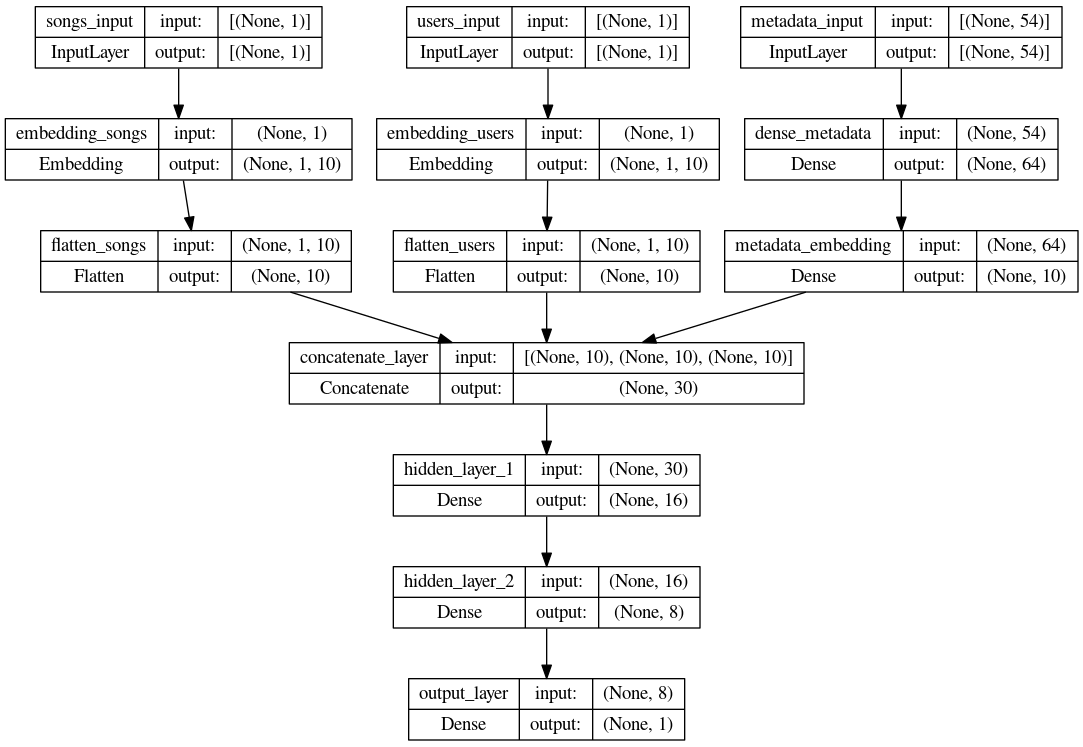

In [56]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model.png')